# Temperature prediction using LSTM and Random Forest 

## **<span style = 'color:green'>1. Import the required libraries</span>**<a id ="Import"></a>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)


C:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


1 Physical GPUs, 1 Logical GPU


## **<span style = 'color:green'>2. Dataset</span>**<a id ="Import"></a>

This dataset was created by measuring temperature humidity in and around a house at an interval of 3.3 minutes. Afterwards the data was averaged at 10 minutes per collection. 

The collection porccess spans for 10 months, and the method of collection was zigbee sensors.

In [2]:
df = pd.read_csv('UCI_data.csv')
df.describe()


,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,101.496833
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,104.380829
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,50.000000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,60.000000
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,100.000000
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000


### **<span style = 'color:green'>2.1 Data information and sorting</span>**<a id ="Import"></a>
**Some more information regarding the dataset columns from the dataset page:**
1. T1, Temperature in kitchen area, in Celsius
2. RH_1, Humidity in kitchen area, in %
3. T2, Temperature in living room area, in Celsius
4. RH_2, Humidity in living room area, in %
5. T3, Temperature in laundry room area
6. RH_3, Humidity in laundry room area, in %
7. T4, Temperature in office room, in Celsius
8. RH_4, Humidity in office room, in %
9. T5, Temperature in bathroom, in Celsius
10. RH_5, Humidity in bathroom, in %
11. T6, Temperature outside the building (north side), in Celsius
12. RH_6, Humidity outside the building (north side), in %
13. T7, Temperature in ironing room , in Celsius
14. RH_7, Humidity in ironing room, in %
15. T8, Temperature in teenager room 2, in Celsius
16. RH_8, Humidity in teenager room 2, in %
17. T9, Temperature in parents room, in Celsius
18. RH_9, Humidity in parents room, in %
19. To, Temperature outside (from Chievres weather station), in Celsius
20. Pressure (from Chievres weather station), in mm Hg
21. RH_out, Humidity outside (from Chievres weather station), in %
22. Wind speed (from Chievres weather station), in m/s
23. Visibility (from Chievres weather station), in km
24. Tdewpoint (from Chievres weather station), Â°C
25. rv1, Random variable 1, nondimensional
26. rv2, Random variable 2, nondimensional

*For our purposes, we will only refer to **RH_4** and **T4** in this notebook, since it is described as an office room, which is an environment similar to the target deployment area of this model.*

In [3]:
print(df[['date', 'T4', 'RH_4']].head(5).to_latex())

\begin{tabular}{llrr}
\toprule
{} &                 date &         T4 &       RH\_4 \\
\midrule
0 &  2016-04-19 20:30:00 &  22.318571 &  36.610000 \\
1 &  2016-03-05 04:40:00 &  18.700000 &  36.260000 \\
2 &  2016-03-14 12:40:00 &  21.000000 &  34.826667 \\
3 &  2016-01-22 15:30:00 &  16.100000 &  38.790000 \\
4 &  2016-02-10 00:40:00 &  19.100000 &  40.900000 \\
\bottomrule
\end{tabular}



C:\Users\victo\AppData\Local\Temp\ipykernel_1904\3158411813.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[['date', 'T4', 'RH_4']].head(5).to_latex())


We can see that the dataset is not sorted, which might become troublesome later on when plotting and reading data, so it is necessary to sort it. We also have to transform the **date** column from strings to actula date objects

In [4]:
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
print(df[['date', 'T4', 'RH_4']].head(5).to_latex())

\begin{tabular}{llrr}
\toprule
{} &                date &         T4 &       RH\_4 \\
\midrule
18486 & 2016-01-11 17:00:00 &  19.000000 &  45.566667 \\
7445  & 2016-01-11 17:10:00 &  19.000000 &  45.992500 \\
14757 & 2016-01-11 17:20:00 &  18.926667 &  45.890000 \\
11475 & 2016-01-11 17:30:00 &  18.890000 &  45.723333 \\
1718  & 2016-01-11 17:40:00 &  18.890000 &  45.530000 \\
\bottomrule
\end{tabular}



C:\Users\victo\AppData\Local\Temp\ipykernel_1904\306045465.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[['date', 'T4', 'RH_4']].head(5).to_latex())


We can observer that the index was not sorted together with the data, which is expected, but since we will replace the index with the date it doens't matter. 

In [5]:
df = df.set_index('date')
df

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,...,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,90
2016-01-11 17:10:00,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,...,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,90
2016-01-11 17:20:00,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,...,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,80
2016-01-11 17:30:00,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,...,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,90
2016-01-11 17:40:00,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,...,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,...,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,100
2016-05-27 17:30:00,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,...,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,90
2016-05-27 17:40:00,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,...,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,280


To allow the model to have a better understanding of the periodicity of year, we will add 2 new columns describing the day of the year and the hour of the day

In [6]:
df['Day'] = df.index.dayofyear
df['Hour'] = df.index.hour
print(df[['Day', 'Hour', 'T4']].describe().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &           Day &          Hour &            T4 \\
\midrule
count &  19735.000000 &  19735.000000 &  19735.000000 \\
mean  &     79.732556 &     11.502002 &     20.855335 \\
std   &     39.564943 &      6.921953 &      2.042884 \\
min   &     11.000000 &      0.000000 &     15.100000 \\
25\%   &     45.000000 &      6.000000 &     19.530000 \\
50\%   &     80.000000 &     12.000000 &     20.666667 \\
75\%   &    114.000000 &     17.000000 &     22.100000 \\
max   &    148.000000 &     23.000000 &     26.200000 \\
\bottomrule
\end{tabular}



C:\Users\victo\AppData\Local\Temp\ipykernel_1904\110673800.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[['Day', 'Hour', 'T4']].describe().to_latex())


It is possible to resample the data at this step, to make the intervals a bit wider, but in this case I don't think it is necessary

In [7]:
#RESAMPLE AT 30 minutes!
#df = df.set_index('date').resample(rule='30T').ffill().interpolate(method='time').reset_index()
#df

### **<span style = 'color:green'>2.2 Some plots</span>**<a id ="Import"></a>


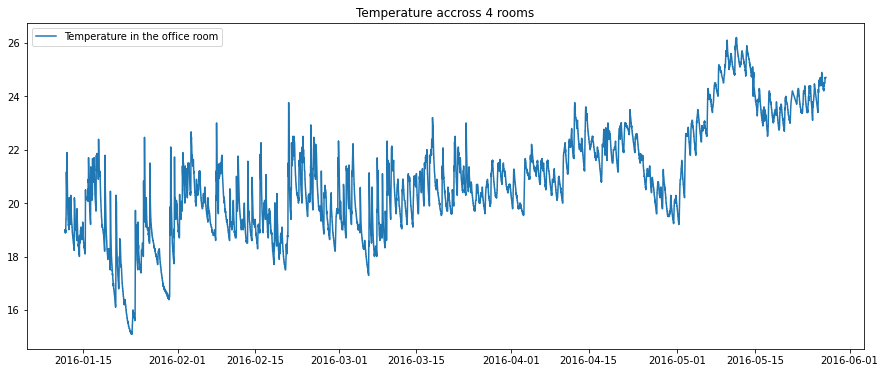

In [8]:
plt.figure(figsize=(15,6))
plt.title('Temperature accross 4 rooms')
plt.plot(df['T4'], label="Temperature in the office room")
plt.legend()
plt.savefig("uci")

### **<span style = 'color:green'>3 Preparing the data for training</span>**<a id ="Import"></a>

We want to predict the temperature inside a room 1 hour into the future. Considering that this data is sampled every 10 minutes, this means that our window size is 6. In more simple terms we want to shift the target-data 6 times(6 * 10 minutes = 1 hour)

In [9]:
shift_times = 6
target = ['T4']
input_data = ['T4', 'Day', 'Hour']
df_input = df[input_data]
df_input

,T4,Day,Hour
date,,,
2016-01-11 17:00:00,19.000000,11,17
2016-01-11 17:10:00,19.000000,11,17
2016-01-11 17:20:00,18.926667,11,17
2016-01-11 17:30:00,18.890000,11,17
2016-01-11 17:40:00,18.890000,11,17
...,...,...,...
2016-05-27 17:20:00,24.700000,148,17
2016-05-27 17:30:00,24.700000,148,17
2016-05-27 17:40:00,24.700000,148,17


In [10]:
df_target = df_input[target].shift(-shift_times)

Important to note that we use `-shift_times`, since we want to predict the **FUTURE** and not the past

In [11]:
df[target].head(shift_times + 5)

,T4
date,
2016-01-11 17:00:00,19.000000
2016-01-11 17:10:00,19.000000
2016-01-11 17:20:00,18.926667
2016-01-11 17:30:00,18.890000
2016-01-11 17:40:00,18.890000
2016-01-11 17:50:00,18.890000
2016-01-11 18:00:00,18.890000
2016-01-11 18:10:00,18.890000
2016-01-11 18:20:00,18.890000


In [12]:
df_target.head(5)

,T4
date,
2016-01-11 17:00:00,18.89
2016-01-11 17:10:00,18.89
2016-01-11 17:20:00,18.89
2016-01-11 17:30:00,18.89
2016-01-11 17:40:00,18.89


In [13]:
df_target.tail()

,T4
date,
2016-05-27 17:20:00,NaN
2016-05-27 17:30:00,NaN
2016-05-27 17:40:00,NaN
2016-05-27 17:50:00,NaN
2016-05-27 18:00:00,NaN


We can see the shape of input data and the expected output data shape -> 3 input signals and 1 output signal

In [14]:
x_data = df_input.values[:-shift_times]
print(x_data.shape)
y_data = df_target.values[:-shift_times].reshape(-1,1)
print(y_data.shape)
num_data = len(x_data)
print(num_data)

(19729, 3)
(19729, 1)
19729


In [15]:
num_x_signals = x_data.shape[1]
num_x_signals
num_y_signals = y_data.shape[1]
num_y_signals

1

Define training information

In [16]:
train_split = 0.8
num_train = int(train_split * num_data)
num_train

15783

In [17]:
num_test = num_data - num_train
num_test

3946

Split the data into train and test

In [18]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

19729

In [19]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

19729

Scale the data since temperature can vary by quite a bit

In [20]:
print("Min:",  np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 121.0


In [21]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [22]:
print("Min:",  np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [23]:
x_test_scaled = x_scaler.transform(x_test)

In [24]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [25]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(15783, 3)
(15783, 1)


In [26]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [27]:
batch_size = 256


In [28]:
sequence_length = 10 * 6 * 24 # we look 1 days in the future
sequence_length

1440

In [29]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [30]:
x_batch, y_batch = next(generator)

In [31]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1440, 3)
(256, 1440, 1)


In [32]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                  np.expand_dims(y_test_scaled, axis=0))

In [33]:
model = Sequential()


In [34]:
model.add(LSTM(units=256, return_sequences=True, input_shape=(None,num_x_signals,)))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

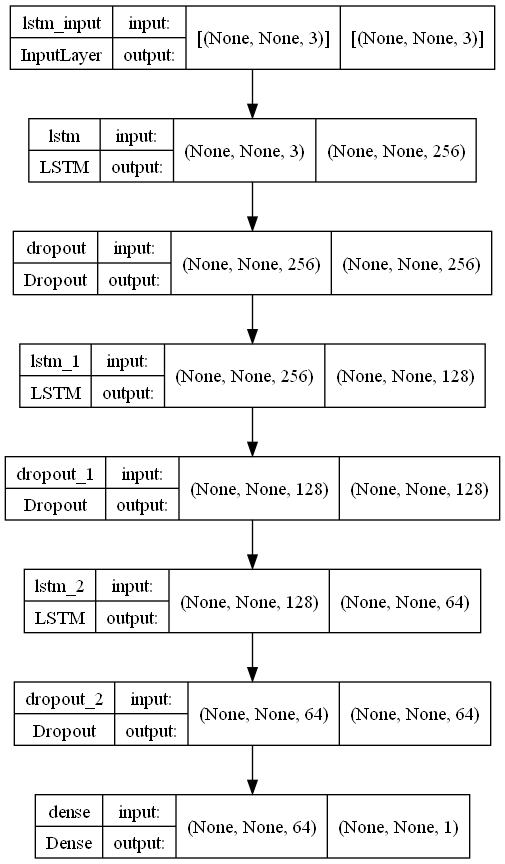

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [36]:
warmup_steps = 50

In [37]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [38]:
optimizer = RMSprop(learning_rate=1e-3)

In [39]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         266240    
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         197120    
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          49408     
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 1)           6

In [41]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=False,
                                      save_best_only=True)

In [42]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [43]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [44]:
callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [45]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [46]:
%%time
model.fit(x=generator,
          epochs=50,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.0317
Epoch 1: val_loss improved from inf to 0.09270, saving model to 23_checkpoint.keras
100/100 [==============================] - 49s 418ms/step - loss: 0.0317 - val_loss: 0.0927 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.0126
Epoch 2: val_loss improved from 0.09270 to 0.05080, saving model to 23_checkpoint.keras
100/100 [==============================] - 42s 416ms/step - loss: 0.0126 - val_loss: 0.0508 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.0096
Epoch 3: val_loss improved from 0.05080 to 0.03502, saving model to 23_checkpoint.keras
100/100 [==============================] - 42s 416ms/step - loss: 0.0096 - val_loss: 0.0350 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.0079
Epoch 4: val_loss did not improve from 0.03502
100/100 [==============================] - 41s 412ms/step - loss: 0.00

In [47]:
# model = tf.keras.models.load_model(path_checkpoint, custom_objects={'loss_mse_warmup':                   
# loss_mse_warmup})
# model.save('saved_model/lstm_model')
# import os

# os.path.abspath('saved_model/lstm_model')
# model = tf.keras.models.load_model('saved_model/lstm_model', custom_objects={'loss_mse_warmup':                   
# loss_mse_warmup})

# converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/lstm_model')


In [48]:
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]

# lite_model = converter.convert()

In [49]:
# with open('lstm_model.tflite', 'wb') as f:
#     f.write(lite_model)

In [50]:
# interpreter = tf.lite.Interpreter(model_path="lstm_model.tflite")

In [51]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))


1/1 [==============================] - 0s 284ms/step - loss: 8.1028e-04


In [52]:
print(result)

0.000810281781014055


In [107]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error

def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled

    # Get the true output-signal from the data-set.
    signal_true = y_true

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    print(y_true.shape)
    print(y_pred[:,:,0].reshape(-1,1).shape)
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', 'Model1',':', mean_absolute_error(y_true,y_pred_rescaled))
    print('Mean Squared Error(MSE) of', 'Model1',':', mean_squared_error(y_true, y_pred_rescaled))
    print('Root Mean Squared Error (RMSE) of', 'Model1',':', mean_squared_error(y_true, y_pred_rescaled, squared = False))
    print('Mean absolute percentage error (MAPE) of', 'Model1',':', mean_absolute_percentage_error(y_true,y_pred_rescaled))
    print('Explained Variance Score (EVS) of', 'Model1',':', explained_variance_score(y_true,y_pred_rescaled))
    print('R2 of', 'Model1',':', (r2_score(y_true, y_pred_rescaled)).round(2))
    print('\n \n')
    # Plot labels etc.
    plt.ylabel(target)
    plt.legend()
    plt.savefig('model2_preidcionts')
    plt.show()

(1000, 1)
(1000, 1)

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Model1 : 0.15082459849039753
Mean Squared Error(MSE) of Model1 : 0.0838999137121717
Root Mean Squared Error (RMSE) of Model1 : 0.2896548182098335
Mean absolute percentage error (MAPE) of Model1 : 0.007226135417533903
Explained Variance Score (EVS) of Model1 : 0.81787377806085
R2 of Model1 : 0.81

 



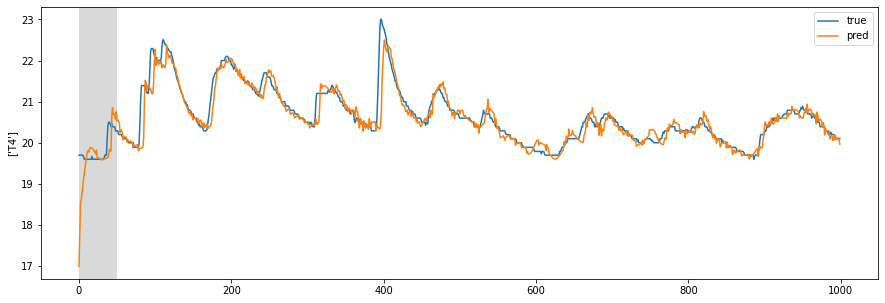

In [108]:
plot_comparison(start_idx=10000, length=1000, train=True)

(1000, 1)
(1000, 1)

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Model1 : 0.14405093877156663
Mean Squared Error(MSE) of Model1 : 0.13723062627757687
Root Mean Squared Error (RMSE) of Model1 : 0.37044652283099766
Mean absolute percentage error (MAPE) of Model1 : 0.00669155930292969
Explained Variance Score (EVS) of Model1 : 0.9134770173297008
R2 of Model1 : 0.91

 



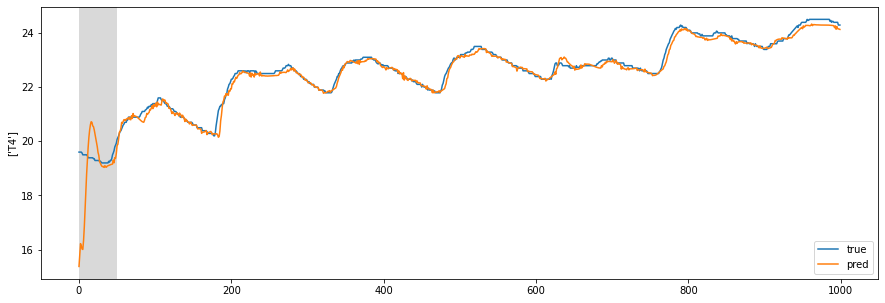

In [109]:
plot_comparison(start_idx=100, length=1000, train=False)

In [56]:
something = x_test_scaled
something = np.expand_dims(something, axis=0)

In [57]:
x_test.shape
# y_pred = model.predict(something)

(3946, 3)

In [58]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [ ]:
df_input


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator


In [ ]:
train_split = 0.8
num_train = int(train_split * num_data)
num_train

In [ ]:
train_data = df_input[:num_train]
x_train_data = train_data.values
y_train_data = train_data['T4'].values

x_train_data_scaled = y_scaler.fit_transform(x_train_data)
y_train_data_scaled = y_scaler.fit_transform(y_train_data.reshape(-1,1))

test_data = df_input[num_train:]

x_test_data = test_data.values
y_test_data = test_data['T4'].values

x_test_data_scaled = x_scaler.transform(x_test_data)
y_test_data_scaled = y_scaler.transform(y_test_data.reshape(-1,1))


In [ ]:
generatorts = Timeserie sGenerator(x_train_data_scaled, y_train_data_scaled, length=6, batch_size=256)

In [ ]:
model2 = Sequential()
# model2.add(LSTM(units=512, return_sequences=True, input_shape=(6,3)))
# model2.add(LSTM(units=256, return_sequences=True, input_shape=(6,3)))
# model2.add(Dense(1))
model2.add(LSTM(units=512, return_sequences=True, input_shape=(6,3)))
model2.add(Dropout(0.2))
model2.add(LSTM(256,activation='tanh',return_sequences=True))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='linear'))

In [ ]:
model2.compile(loss="mse", optimizer="adam")

In [ ]:
model2.summary()

In [ ]:
%%time
callbacks2 = [callback_early_stopping,
             callback_tensorboard,
             callback_reduce_lr]
generatorts[10000][0].shape
model2.fit(generatorts,
          epochs=25,
          callbacks=callbacks2)

In [ ]:
last_train_batch = x_train_scaled
last_train_batch = np.expand_dims(last_train_batch, axis=0)

In [ ]:
pred_model2 = model.predict(last_train_batch)
pred_model2.shape

In [ ]:
my_data = []
pred_model2_reverse_scaled = y_scaler.inverse_transform(pred_model2.reshape(-1,1))
for i in pred_model2_reverse_scaled:
    my_data.append(i[-1])
len(my_data[::6])

In [ ]:
my_data2 = []
x_data_reverse_scaled_model2 = x_scaler.inverse_transform(x_test_data_scaled[:2631])
for i in x_data_reverse_scaled_model2:
    my_data2.append(i[0])
len(my_data2)

In [ ]:
plt.plot(my_data[::6])
plt.plot(my_data2)

In [ ]:

test_predictions = []

first_eval_batch = x_train_scaled[-6:]
current_batch = first_eval_batch.reshape((1, 6, 3))



for i in range(len(x_test_data)):
    # get the prediction value for the first batch
    print(current_batch.shape)
    current_pred = model.predict(current_batch)
    test_predictions.append(current_pred)
    
    # print(current_pred[0][-1][0])
    current_branch = np.delete(current_batch, 0, axis=1)
    print(current_branch.shape)
    pred = np.asarray([current_pred[0][-1][0], 1., 0.30434783])
    pred = pred.reshape(-1,1,3)
    current_batch = np.append(current_batch, pred, axis = 1)

    


# 

ts:0x00124b002917f1bf:temperature
(371, 1, 3)
rescaled_prediction [[26.619646]
 [25.437447]
 [25.445745]
 [24.43953 ]
 [23.988157]
 [23.560474]
 [23.560474]
 [23.560474]
 [23.706398]
 [24.659134]
 [24.659134]
 [24.659134]
 [25.239698]
 [25.239698]
 [25.244156]
 [25.244156]
 [25.973085]
 [25.973085]
 [26.492891]
 [26.492891]
 [26.513042]
 [26.513042]
 [26.16446 ]
 [26.683475]
 [26.683475]
 [26.683475]
 [26.179647]
 [26.179647]
 [26.179647]
 [26.331047]
 [26.331047]
 [26.35262 ]
 [26.369484]
 [26.958439]
 [26.420847]
 [25.885107]
 [26.01247 ]
 [26.01247 ]
 [26.024721]
 [25.435144]
 [24.908703]
 [24.908703]
 [24.495615]
 [24.495615]
 [24.488632]
 [24.488632]
 [25.03213 ]
 [24.512878]
 [24.512878]
 [25.620256]
 [27.391409]
 [27.87133 ]
 [26.735111]
 [26.735111]
 [26.153717]
 [25.159185]
 [23.601511]
 [23.601511]
 [23.149021]
 [23.149021]
 [22.70998 ]
 [22.70998 ]
 [22.427336]
 [22.270782]
 [22.270782]
 [22.270782]
 [22.270782]
 [22.270782]
 [22.113478]
 [22.113478]
 [22.113478]
 [21.88123 

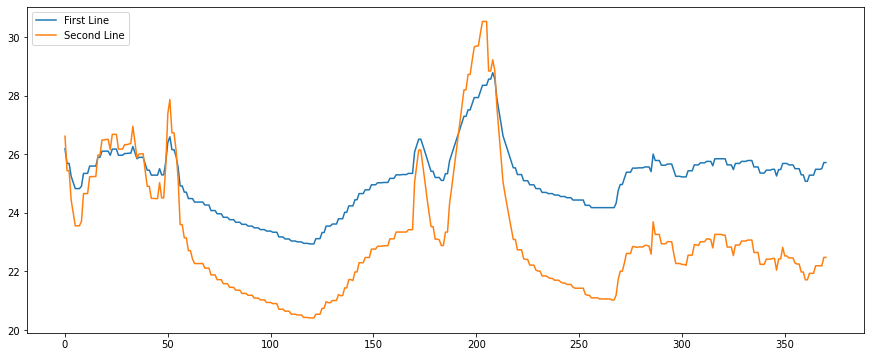

[[26.619646]
 [25.437447]
 [25.445745]
 [24.43953 ]
 [23.988157]
 [23.560474]
 [23.560474]
 [23.560474]
 [23.706398]
 [24.659134]
 [24.659134]
 [24.659134]
 [25.239698]
 [25.239698]
 [25.244156]
 [25.244156]
 [25.973085]
 [25.973085]
 [26.492891]
 [26.492891]
 [26.513042]
 [26.513042]
 [26.16446 ]
 [26.683475]
 [26.683475]
 [26.683475]
 [26.179647]
 [26.179647]
 [26.179647]
 [26.331047]
 [26.331047]
 [26.35262 ]
 [26.369484]
 [26.958439]
 [26.420847]
 [25.885107]
 [26.01247 ]
 [26.01247 ]
 [26.024721]
 [25.435144]
 [24.908703]
 [24.908703]
 [24.495615]
 [24.495615]
 [24.488632]
 [24.488632]
 [25.03213 ]
 [24.512878]
 [24.512878]
 [25.620256]
 [27.391409]
 [27.87133 ]
 [26.735111]
 [26.735111]
 [26.153717]
 [25.159185]
 [23.601511]
 [23.601511]
 [23.149021]
 [23.149021]
 [22.70998 ]
 [22.70998 ]
 [22.427336]
 [22.270782]
 [22.270782]
 [22.270782]
 [22.270782]
 [22.270782]
 [22.113478]
 [22.113478]
 [22.113478]
 [21.88123 ]
 [21.88123 ]
 [21.88123 ]
 [21.718962]
 [21.718962]
 [21.718962]

In [113]:
import tensorflow as tf
import redis
import datetime
import pandas as pd
import numpy as np
from tensorflow.keras.backend import square, mean
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.

    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, 50:, :]
    y_pred_slice = y_pred[:, 50:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))

    return mse


class RedisGetter:
    def __init__(self, device_name, property_name):
        self.device_name = device_name
        self.property_name = property_name
        self.connect_to_db()

        self.key = f"ts:{self.device_name[1:]}:{self.property_name}"

    def connect_to_db(self):
        self.r = redis.Redis(
            host="192.168.100.152",
            port=6379,
        )

    def get_parameter_info_ts_range(self):
        # message = self.r.info()
        ts = self.r.ts()
        print(self.key)
        info = ts.info(self.key)
        return (info.first_timestamp, info.last_timestamp)

    def get_data_in_range(self):
        range = self.get_parameter_info_ts_range()

        data = self.r.ts()
        range_data = data.range(self.key, range[0], range[1])
        return range_data

    def parse_range_data(self, resample_value="5T"):
        range_data = self.get_data_in_range()
        ts, param = zip(*range_data)
        ts = list(ts)
        param = list(param)

        ts_string = [
            datetime.datetime.fromtimestamp(int(ts / 1000)).strftime(
                "%Y-%m-%d %H:%M:%S"
            )
            for ts in ts
        ]
        ts_date = [
            datetime.datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in ts_string
        ]
        device_data = pd.DataFrame(
            {"Date": ts_date, self.property_name: param})
        device_data["Date"] = pd.to_datetime(device_data["Date"])
        device_data = (
            device_data.set_index("Date")
            .resample(rule=resample_value[:-1])
            .bfill()
        )
        return device_data


class ModelPredictor():
    def __init__(self, device, key):
        self.data = RedisGetter(device,
                                key).parse_range_data("10T\"")

    def load_model(self, path):
        return tf.keras.models.load_model(path, custom_objects={'loss_mse_warmup':
                                                                loss_mse_warmup})

    def prepare_input_data(self, input_data):
        self.x_scaler = MinMaxScaler()
        data = self.x_scaler.fit_transform(input_data)
        return data

    def prepare_output_data(self, output_data):
        self.y_scaler = MinMaxScaler()
        self.y_scaler.fit_transform(output_data)

    def make_prediction(self):
        data = self.data

        data['Day'] = data.index.dayofyear
        data['Hour'] = data.index.hour
        input_data_keys = ['temperature', 'Day', 'Hour']
        df_input = data[input_data_keys]
        df_output = data['temperature'].values.reshape(-1, 1)
        model = self.load_model('23_checkpoint.keras')

        scaled_input_data = self.prepare_input_data(df_input.values)
        self.prepare_output_data(df_output)

        scaled_input_data = np.expand_dims(scaled_input_data, axis=1)
        print(scaled_input_data.shape)
        prediction = model.predict(scaled_input_data)
        # print(prediction[:,0])
        prediction_rescaled = self.y_scaler.inverse_transform(
            prediction[:,0])
        
        print("rescaled_prediction", prediction_rescaled)
        print(df_input.values)
        plt.figure(figsize=(15,6))
        plt.plot(df_input['temperature'].values, label='First Line')
        plt.plot( prediction_rescaled,label='Second Line')
        plt.legend(loc="upper left")
        plt.savefig('actual_predictions_model2')
        plt.show()

        return prediction_rescaled


x = ModelPredictor("\"0x00124b002917f1bf", "temperature").make_prediction()
print(x)
